## 3. Purely Louvain Algorithm Implementation

In [182]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import time
import community as community_louvain
import tracemalloc
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pickle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [183]:
emb_norm = np.load("../data/embeddings_FINAL.npy") 
games_df = pd.read_pickle("../data/games_df_FINAL.pkl")

# print(emb_norm.shape)
# print(games_df.shape)

### 3.1 Construct Louvain's Starting Graph with weighted edges based in cosine similarity

In [184]:
# build a graph for a given threshold
def build_graph_from_sim(sim_matrix, threshold: float) -> nx.Graph:
    """
    Build an undirected graph where nodes are indices in sim_matrix
    and edges are added for similarities > threshold.
    """
    t0 = time.time()
    n = sim_matrix.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(n))

    # Vectorized: find all (i, j) with sim > threshold and i<j
    rows, cols = np.where(sim_matrix > threshold)
    mask = rows < cols
    rows, cols = rows[mask], cols[mask]

    for i, j in zip(rows, cols):
        G.add_edge(int(i), int(j), weight=float(sim_matrix[i, j]))
        
    print(
        f"Graph built: nodes={G.number_of_nodes()}, "
        f"edges={G.number_of_edges()}, "
        f"time={time.time() - t0:.2f}s"
    )

    return G

In [185]:
# Cosine similarity
t0 = time.time()
sim_matrix = cosine_similarity(emb_norm)
print("Cosine similarity done in:", time.time() - t0, "sec")

Cosine similarity done in: 1.0190174579620361 sec


In [186]:
# === Example with threshold 0.8 ===

threshold = 0.8  # Do not add all edges

G = build_graph_from_sim(sim_matrix, threshold)

print("Vertices:", G.number_of_nodes())
print("Edges:", G.number_of_edges()) 

Graph built: nodes=10476, edges=2390, time=0.49s
Vertices: 10476
Edges: 2390


### 3.2 Execute Louvain, Save & Analysis

In [187]:
def evaluate_louvain(
    G: nx.Graph,
    embeddings: np.ndarray,
    resolution: float = 1.0,
    seed: int = 0,
) -> dict:
    """
    Run Louvain on graph G, compute:
    - modularity
    - #clusters, cluster sizes
    - silhouette, Davies–Bouldin on embeddings
    - runtime, peak memory
    Returns a dict of metrics.
    """
    # Measure memory + time
    tracemalloc.start()
    t0 = time.time()

    partition = community_louvain.best_partition(
        G,
        weight="weight",
        resolution=resolution,
        random_state=seed,
    )

    runtime = time.time() - t0
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    peak_mb = peak / (1024 ** 2)

    # Partition -> labels array aligned with node indices
    # nodes are 0..N-1, same as rows in embeddings
    labels = np.array([partition[i] for i in range(len(partition))])
    n_clusters = len(np.unique(labels))

    # Cluster size stats
    cluster_sizes = pd.Series(labels).value_counts()
    largest_cluster = int(cluster_sizes.max())
    smallest_cluster = int(cluster_sizes.min())

    # Modularity
    modularity = community_louvain.modularity(partition, G, weight="weight")

    # Silhouette / DB on embeddings (only if >1 cluster and not all singletons)
    try:
        if n_clusters > 1 and largest_cluster > 1:
            sil = silhouette_score(embeddings, labels)
            db = davies_bouldin_score(embeddings, labels)
        else:
            sil = np.nan
            db = np.nan
    except Exception as e:
        print("Metric error:", e)
        sil = np.nan
        db = np.nan

    return {
        "resolution": resolution,
        "seed": seed,
        "n_clusters": n_clusters,
        "largest_cluster": largest_cluster,
        "smallest_cluster": smallest_cluster,
        "modularity": modularity,
        "silhouette": sil,
        "davies_bouldin": db,
        "runtime_sec": runtime,
        "peak_mem_mb": peak_mb,
    }, partition


In [188]:
# Run evaluation for the example from before
metrics, partition = evaluate_louvain(G, emb_norm, resolution=1.0, seed=42)

In [189]:
# Save outputs of the example
with open("partition_louvain_puro.pkl", "wb") as f:
    pickle.dump(partition, f)

with open("graph_louvain_puro.pkl", "wb") as f:
    pickle.dump(G, f)

print("Saved Louvain outputs.")

Saved Louvain outputs.


#### 3.2.1 Louvain's Evaluation

In [190]:
# Evaluation of the example

cluster_sizes = Counter(partition.values())
print("Cluster size distribution:")
for cid, size in cluster_sizes.most_common():
    print(f"Cluster {cid}: {size} games")

Cluster size distribution:
Cluster 167: 65 games
Cluster 190: 55 games
Cluster 69: 46 games
Cluster 592: 30 games
Cluster 786: 28 games
Cluster 413: 22 games
Cluster 2029: 22 games
Cluster 3312: 22 games
Cluster 263: 21 games
Cluster 354: 21 games
Cluster 1658: 19 games
Cluster 185: 17 games
Cluster 196: 17 games
Cluster 169: 16 games
Cluster 1607: 16 games
Cluster 2855: 12 games
Cluster 130: 10 games
Cluster 4986: 10 games
Cluster 570: 9 games
Cluster 1411: 9 games
Cluster 685: 8 games
Cluster 2271: 8 games
Cluster 4732: 7 games
Cluster 426: 6 games
Cluster 1490: 6 games
Cluster 119: 5 games
Cluster 176: 5 games
Cluster 258: 5 games
Cluster 265: 5 games
Cluster 959: 5 games
Cluster 1259: 5 games
Cluster 2152: 5 games
Cluster 2325: 5 games
Cluster 2602: 5 games
Cluster 2982: 5 games
Cluster 3578: 5 games
Cluster 70: 4 games
Cluster 208: 4 games
Cluster 328: 4 games
Cluster 433: 4 games
Cluster 765: 4 games
Cluster 1039: 4 games
Cluster 1046: 4 games
Cluster 1121: 4 games
Cluster 1714: 

In [191]:
def average_intra_cluster_similarity(sim_matrix, partition):
    clusters = {}
    for node, cid in partition.items():
        clusters.setdefault(cid, []).append(node)

    intra_sims = {}

    for cid, nodes in clusters.items():
        if len(nodes) < 2:
            intra_sims[cid] = 0
            continue

        sims = []
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                sims.append(sim_matrix[nodes[i], nodes[j]])

        intra_sims[cid] = np.mean(sims)

    return intra_sims

intra = average_intra_cluster_similarity(sim_matrix, partition)

print("\nAverage intra-cluster similarity:")
for cid, sim in sorted(intra.items(), key=lambda x: -x[1])[:10]:
    print(f"Cluster {cid}: {sim:.4f}")


Average intra-cluster similarity:
Cluster 5984: 1.0000
Cluster 4830: 0.9995
Cluster 6742: 0.9930
Cluster 4998: 0.9877
Cluster 5034: 0.9876
Cluster 1490: 0.9840
Cluster 5753: 0.9819
Cluster 4840: 0.9806
Cluster 4407: 0.9774
Cluster 3625: 0.9715


### Visual analysis for Louvains algorithm

In [192]:
def inspect_cluster(cluster_id, df, partition, n=30):
    # node ids from Louvain partition
    node_ids = [i for i, c in partition.items() if c == cluster_id]

    # keep only ids that are valid row positions in df
    valid_ids = [i for i in node_ids if 0 <= i < len(df)]
    dropped = len(node_ids) - len(valid_ids)
    if dropped > 0:
        print(f"Warning: dropped {dropped} nodes not in [0, {len(df)-1}]")

    if not valid_ids:
        print(f"No nodes from cluster {cluster_id} are present in the current df.")
        return

    # now this can't be out-of-bounds
    df_cluster = df.iloc[valid_ids]

    print(f"Cluster {cluster_id} - size={len(df_cluster)}\n")

    # Top genres (adapt column name if needed)
    if "genres" in df_cluster.columns:
        print("Top genres:")
        print(df_cluster["genres"].value_counts().head(10))
        print()

    # Top platforms, if present
    for col in ["platforms", "platform", "main_platform"]:
        if col in df_cluster.columns:
            print(f"Top {col}:")
            print(df_cluster[col].value_counts().head(10))
            print()
            break

    print("Sample games:")
    cols = [c for c in ["game_id", "name", "genres"] if c in df_cluster.columns]
    display(df_cluster[cols].head(n))


In [193]:
inspect_cluster(69, games_df, partition)

Cluster 69 - size=46

Top genres:
genres
Indie                                   24
Indie, Strategy                          9
Indie, Puzzle                            5
Adventure, Indie                         4
Puzzle                                   1
Indie, Simulator, Sport                  1
Adventure, Indie, Role-playing (RPG)     1
Indie, Sport                             1
Name: count, dtype: int64

Top platforms:
platforms
PC (Microsoft Windows)         37
Mac, PC (Microsoft Windows)     9
Name: count, dtype: int64

Sample games:


,game_id,name,genres
69,343605,Hentai Beach,"Indie, Puzzle"
229,161575,Hentai Fantasy,"Indie, Strategy"
1251,197305,Naughty Waifu,Indie
1317,265767,Hentai Vivian,Indie
1819,286722,Hentai Karada,"Indie, Strategy"
1887,286726,Hentai Sakyubus,"Indie, Strategy"
2038,286723,Hentai Hentai,"Indie, Strategy"
2638,173853,Neko Hentai Girl,"Adventure, Indie"
3816,156637,Hentai Balloons 2,Indie
3829,177629,Hentai Clouds,Puzzle


### Louvains algorithm implementation with different thresholds and evaluation

In [194]:
thresholds = [0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
resolutions = [0.5, 1.0, 1.5]
seeds = [0]

results = []
partitions_cache = {}  # key: (thr, res, seed) -> partition

for thr in thresholds:
    print(f"\n=== Threshold {thr} ===")
    G_thr = build_graph_from_sim(sim_matrix, thr)
    
    for res in resolutions:
        for seed in seeds:
            print(f"  -> Louvain: res={res}, seed={seed}")
            metrics, partition = evaluate_louvain(
                G_thr,
                emb_norm,
                resolution=res,
                seed=seed,
            )
            metrics_with_thr = {"threshold": thr, **metrics}
            results.append(metrics_with_thr)
            partitions_cache[(thr, res, seed)] = partition

results_df = pd.DataFrame(results)


=== Threshold 0.4 ===
Graph built: nodes=10476, edges=3010936, time=8.13s
  -> Louvain: res=0.5, seed=0
  -> Louvain: res=1.0, seed=0
  -> Louvain: res=1.5, seed=0

=== Threshold 0.5 ===
Graph built: nodes=10476, edges=426116, time=2.97s
  -> Louvain: res=0.5, seed=0
  -> Louvain: res=1.0, seed=0
  -> Louvain: res=1.5, seed=0

=== Threshold 0.6 ===
Graph built: nodes=10476, edges=63942, time=0.58s
  -> Louvain: res=0.5, seed=0
  -> Louvain: res=1.0, seed=0
  -> Louvain: res=1.5, seed=0

=== Threshold 0.65 ===
Graph built: nodes=10476, edges=27442, time=0.63s
  -> Louvain: res=0.5, seed=0
  -> Louvain: res=1.0, seed=0
  -> Louvain: res=1.5, seed=0

=== Threshold 0.7 ===
Graph built: nodes=10476, edges=11714, time=0.40s
  -> Louvain: res=0.5, seed=0
  -> Louvain: res=1.0, seed=0
  -> Louvain: res=1.5, seed=0

=== Threshold 0.75 ===
Graph built: nodes=10476, edges=5075, time=0.40s
  -> Louvain: res=0.5, seed=0
  -> Louvain: res=1.0, seed=0
  -> Louvain: res=1.5, seed=0

=== Threshold 0.8

In [195]:
results_df

,threshold,resolution,seed,n_clusters,largest_cluster,smallest_cluster,modularity,silhouette,davies_bouldin,runtime_sec,peak_mem_mb
0,0.40,0.5,0,357,6261,1,0.189876,-0.092461,1.234882,90.096862,759.169371
1,0.40,1.0,0,20,3262,1,0.284516,0.017489,1.969184,214.781497,758.755286
2,0.40,1.5,0,42,1954,1,0.260726,-0.105735,2.196742,217.446539,758.884832
3,0.50,0.5,0,931,4816,1,0.446915,-0.048380,1.255729,16.582748,112.161957
4,0.50,1.0,0,597,3176,1,0.483272,-0.077570,1.048565,81.297353,112.185759
5,0.50,1.5,0,602,2082,1,0.467201,-0.064767,1.088848,35.234539,112.235258
6,0.60,0.5,0,4721,1036,1,0.611312,0.006275,1.025748,4.397286,22.946995
7,0.60,1.0,0,4263,1634,1,0.643320,-0.051444,1.001206,14.595705,25.418089
8,0.60,1.5,0,4282,1415,1,0.668266,-0.042392,1.002264,10.848536,24.227509
9,0.65,0.5,0,6890,344,1,0.695213,0.028671,0.871856,7.333801,14.251883


##### Ranking configurations

In [210]:
df = results_df.copy()

# Filter out obviously bad clusterings
lower_bound, upper_bound = 3, 10000
df = df[(df["n_clusters"] >= lower_bound) & (df["n_clusters"] <= upper_bound)]

# Normalize metrics we want to maximize
for col in ["modularity", "silhouette"]:
    valid = df[col].replace([np.inf, -np.inf], np.nan)
    if valid.nunique() > 1:
        df[col + "_norm"] = (valid - valid.min()) / (valid.max() - valid.min())
    else:
        df[col + "_norm"] = 0.5  # neutral

# Normalize metrics we want to minimize (invert)
for col in ["davies_bouldin", "runtime_sec", "peak_mem_mb"]:
    valid = df[col].replace([np.inf, -np.inf], np.nan)
    if valid.nunique() > 1:
        df[col + "_norm"] = (valid.max() - valid) / (valid.max() - valid.min())
    else:
        df[col + "_norm"] = 0.5

# Weighted score (chosen a little bit at random)
df["score"] = (
    0.25 * df["modularity_norm"] +       
    0.15 * df["silhouette_norm"] +      
    0.25 * df["davies_bouldin_norm"] +  
    0.20 * df["runtime_sec_norm"] +     
    0.15 * df["peak_mem_mb_norm"]
)

best_configs = df.sort_values("score", ascending=False)
best_configs.head(10)


,threshold,resolution,seed,n_clusters,largest_cluster,smallest_cluster,modularity,silhouette,davies_bouldin,runtime_sec,peak_mem_mb,modularity_norm,silhouette_norm,davies_bouldin_norm,runtime_sec_norm,peak_mem_mb_norm,score
20,0.80,1.5,0,9629,65,1,0.924442,0.024737,0.574254,5.062631,13.137589,0.998990,0.946061,0.999851,0.992858,0.994388,0.989349
19,0.80,1.0,0,9627,65,1,0.925185,0.024118,0.574099,4.967430,13.136924,1.000000,0.941573,0.999947,0.993303,0.994389,0.989042
18,0.80,0.5,0,9625,65,1,0.924431,0.023303,0.574012,4.574875,13.133413,0.998974,0.935669,1.000000,0.995138,0.994394,0.988281
15,0.75,0.5,0,9187,98,1,0.844649,0.032175,0.586696,3.534927,8.927275,0.890473,1.000000,0.992184,1.000000,1.000000,0.970664
16,0.75,1.0,0,9126,120,1,0.872528,0.025690,0.632247,5.114580,13.652656,0.928387,0.952971,0.964113,0.992615,0.993702,0.963649
17,0.75,1.5,0,9128,106,1,0.871274,0.026306,0.631011,5.680870,13.658901,0.926682,0.957438,0.964875,0.989968,0.993693,0.963552
12,0.70,0.5,0,8267,269,1,0.790434,0.023601,0.785870,4.795194,12.763762,0.816742,0.937827,0.869444,0.994108,0.994886,0.910275
13,0.70,1.0,0,8264,249,1,0.791026,0.022789,0.830461,6.642969,17.333029,0.817547,0.931937,0.841965,0.985470,0.988796,0.900082
14,0.70,1.5,0,8266,171,1,0.782049,0.023898,0.830847,6.951830,17.344870,0.805338,0.939983,0.841727,0.984027,0.988780,0.897886
9,0.65,0.5,0,6890,344,1,0.695213,0.028671,0.871856,7.333801,14.251883,0.687245,0.974586,0.816455,0.982241,0.992903,0.867496


##### Visualization

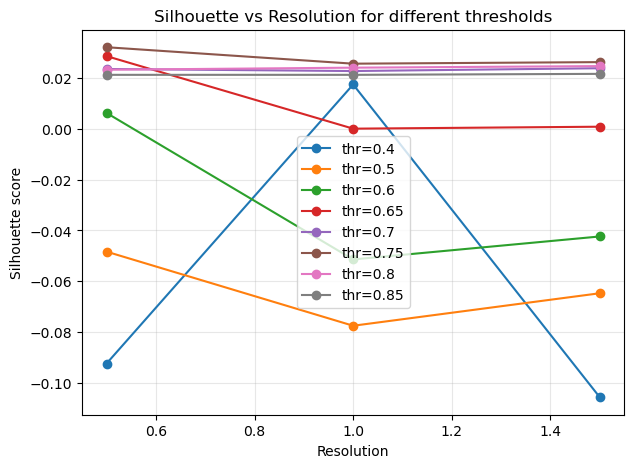

In [211]:
plt.figure(figsize=(7,5))
for thr in thresholds:
    sub = results_df[results_df["threshold"] == thr]
    sub_sorted = sub.sort_values("resolution")
    plt.plot(sub_sorted["resolution"], sub_sorted["silhouette"], marker="o", label=f"thr={thr}")
plt.xlabel("Resolution")
plt.ylabel("Silhouette score")
plt.title("Silhouette vs Resolution for different thresholds")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


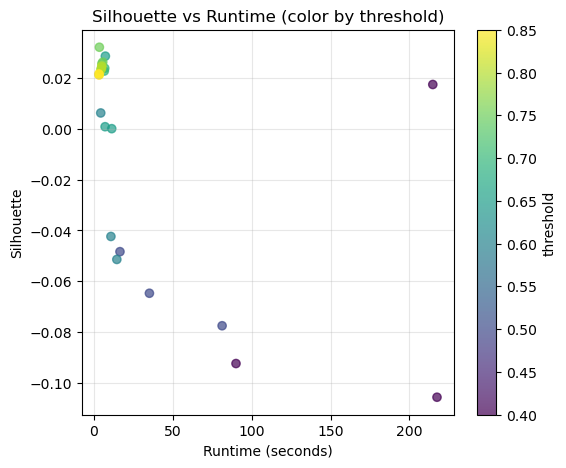

In [212]:
plt.figure(figsize=(6,5))
plt.scatter(results_df["runtime_sec"], results_df["silhouette"], c=results_df["threshold"], cmap="viridis", alpha=0.7)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Silhouette")
plt.title("Silhouette vs Runtime (color by threshold)")
plt.colorbar(label="threshold")
plt.grid(True, alpha=0.3)
plt.show()

##### Visualization of communities in 2D

In [213]:
# This may take a while if you have many nodes; you can sample or reduce dim first.
X_2d = TSNE(
    n_components=2,
    init="random",
    learning_rate="auto",
    perplexity=30,
    max_iter=1000,
    verbose=1,
    ).fit_transform(emb_norm)

def plot_partition_2d(labels, title=""):
    plt.figure(figsize=(7,6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=3, cmap="tab20")
    plt.title(title)
    plt.axis("off")
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10476 samples in 0.007s...
[t-SNE] Computed neighbors for 10476 samples in 1.291s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10476
[t-SNE] Computed conditional probabilities for sample 2000 / 10476
[t-SNE] Computed conditional probabilities for sample 3000 / 10476
[t-SNE] Computed conditional probabilities for sample 4000 / 10476
[t-SNE] Computed conditional probabilities for sample 5000 / 10476
[t-SNE] Computed conditional probabilities for sample 6000 / 10476
[t-SNE] Computed conditional probabilities for sample 7000 / 10476
[t-SNE] Computed conditional probabilities for sample 8000 / 10476
[t-SNE] Computed conditional probabilities for sample 9000 / 10476
[t-SNE] Computed conditional probabilities for sample 10000 / 10476
[t-SNE] Computed conditional probabilities for sample 10476 / 10476
[t-SNE] Mean sigma: 0.253180
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.646591
[t-SNE] KL 

### 3.4 Recommendation Sytem with Louvains Graph

In [214]:
# Take the best configuration (top row in best_configs)
row = best_configs.iloc[0]
thr_best = row["threshold"]
res_best = row["resolution"]
seed_best = int(row["seed"])

print("Best config:", thr_best, res_best, seed_best)

# Get partition for that config
best_partition = partitions_cache[(thr_best, res_best, seed_best)]
labels_best = np.array([best_partition[i] for i in range(len(best_partition))])

Best config: 0.8 1.5 0


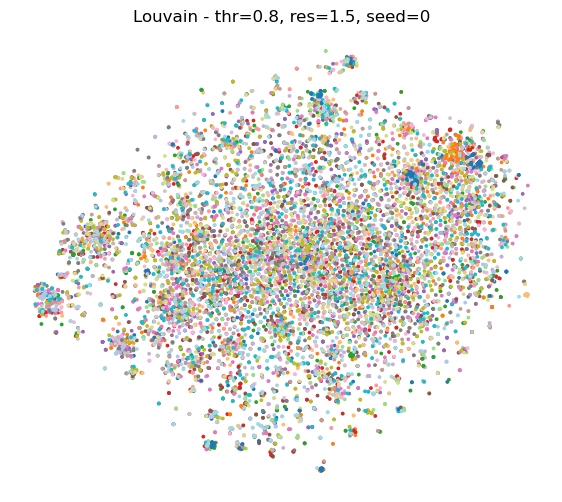

In [215]:
# Visualize communities in 2D
plot_partition_2d(labels_best, title=f"Louvain - thr={thr_best}, res={res_best}, seed={seed_best}")

In [216]:
def plot_top_clusters(X_2d, labels, top_k=15, title="Louvain communities"):
    cluster_sizes = pd.Series(labels).value_counts()
    top_clusters = cluster_sizes.head(top_k).index

    # map top cluster ids -> 0..top_k-1
    color_map = {cid: i for i, cid in enumerate(top_clusters)}
    colors = np.full_like(labels, fill_value=-1, dtype=int)

    for cid in top_clusters:
        colors[labels == cid] = color_map[cid]

    plt.figure(figsize=(8, 7))
    # background: all points in light gray
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c="lightgray", s=2, alpha=0.2)

    # highlight: only top clusters
    mask = colors >= 0
    sc = plt.scatter(
        X_2d[mask, 0],
        X_2d[mask, 1],
        c=colors[mask],
        s=6,
        cmap="tab20",
        alpha=0.9,
    )
    plt.title(f"{title} (top {top_k} clusters)")
    plt.axis("off")
    plt.show()


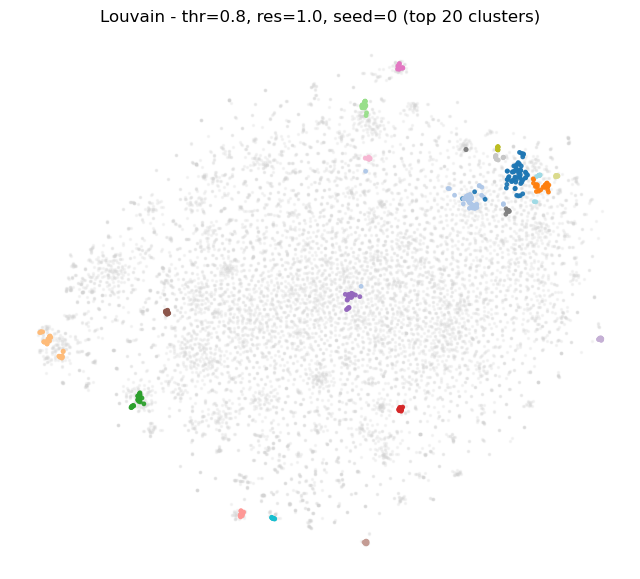

In [217]:
plot_top_clusters(X_2d, labels_best, top_k=20, title="Louvain - thr=0.8, res=1.0, seed=0")

In [218]:
def plot_single_community(cluster_id, X_2d, labels, title_prefix="Cluster"):
    mask = labels == cluster_id

    plt.figure(figsize=(8, 7))
    # all nodes in light gray
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c="lightgray", s=2, alpha=0.2)
    # selected cluster in color
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], c="red", s=6, alpha=0.9)
    plt.title(f"{title_prefix} {cluster_id} (size={mask.sum()})")
    plt.axis("off")
    plt.show()

1315    65
190     55
69      36
593     30
787     28
414     22
2029    22
264     21
355     21
1658    19
Name: count, dtype: int64


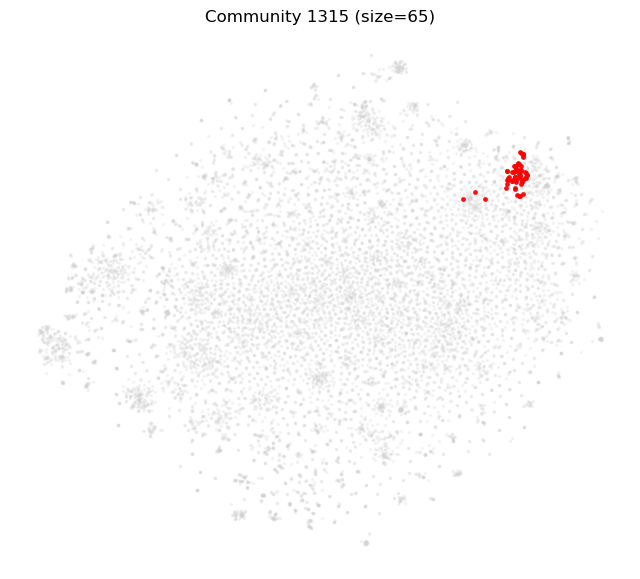

No nodes from cluster 1315 are present in the current df.


In [219]:
cluster_sizes = pd.Series(labels_best).value_counts()
print(cluster_sizes.head(10))  # pick a few interesting cluster IDs

cid = int(cluster_sizes.index[0])  # largest cluster, for example
plot_single_community(cid, X_2d, labels_best, title_prefix="Community")
inspect_cluster(cid, df, best_partition)


In [220]:
def cluster_top_genre(df, labels, max_clusters=50):
    df_tmp = df.copy()
    df_tmp["cluster"] = labels

    rows = []
    for cid, grp in df_tmp.groupby("cluster"):
        if len(rows) >= max_clusters:
            break
        if "genres" not in grp.columns:
            continue
        top_genre = grp["genres"].value_counts().idxmax()
        genre_share = grp["genres"].value_counts(normalize=True).iloc[0]
        rows.append({
            "cluster": cid,
            "size": len(grp),
            "top_genre": top_genre,
            "top_genre_share": genre_share,
        })

    return pd.DataFrame(rows).sort_values("size", ascending=False)

top_genres_per_cluster = cluster_top_genre(games_df, labels_best, max_clusters=len(np.unique(labels_best)))
top_genres_per_cluster.head(10)


,cluster,size,top_genre,top_genre_share
1315,1315,65,Indie,0.353846
190,190,55,Indie,0.763636
69,69,36,Indie,0.638889
593,593,30,Simulator,1.000000
787,787,28,Simulator,1.000000
414,414,22,Indie,0.409091
2029,2029,22,"Adventure, Indie, Racing, Role-playing (RPG), ...",0.863636
355,355,21,"Adventure, Role-playing (RPG)",0.333333
264,264,21,Fighting,0.428571
1658,1658,19,"Adventure, Role-playing (RPG), Simulator, Stra...",0.789474


# Pure Louvain

In [221]:
_partition_cache = None
_graph_cache = None

def recommend_pure_louvain(game_id, embeddings_norm, topk=10):

    global _partition_cache, _graph_cache

    # Load partition
    if _partition_cache is None:
        print("Loading Louvain partition...")
        with open("partition_louvain_puro.pkl", "rb") as f:
            _partition_cache = pickle.load(f)

    # Load graph
    if _graph_cache is None:
        print("Loading Louvain graph...")
        with open("graph_louvain_puro.pkl", "rb") as f:
            _graph_cache = pickle.load(f)

    partition = _partition_cache
    G = _graph_cache
    cluster_id = partition[game_id]
    same_cluster = [
        j for j, c in partition.items()
        if c == cluster_id and j != game_id
    ]

    if len(same_cluster) == 0:
        print("Game is isolated; no recommendations.")
        return []

    sims = [
        (j, float(np.dot(embeddings_norm[game_id], embeddings_norm[j])))
        for j in same_cluster
    ]

    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:topk]

### 3.5 Example of Recommendation by Purely Louvain

In [222]:
game_id = 42
print("Base game:", df.iloc[game_id]["name"])
recs = recommend_pure_louvain(game_id, emb_norm, df)
for idx, sim in recs:
    print(f"{df.iloc[idx]['name']} - sim={sim:.3f}")

IndexError: single positional indexer is out-of-bounds